## Decoder-only Autoregressive Transformer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

import torch
from torch import nn
from torch.utils import data

import sequence as seq
from IPython import display

In [2]:
torch.cuda.is_available()

True

### Setup

In [229]:
############ MultiHeadAttention Class ############

class ScaledDotProductAttention(nn.Module):
    def __init__(self, context_len, dropout, *args, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('tril_mask', torch.tril(torch.ones(context_len, context_len)))
    
    def forward(self, q, k, v, causal_masking=True):
        # shape of q, k, v: (batch_size, n_steps, d_model)
        shape = q.shape
        
        scores = torch.einsum('ijk, ilk -> ijl', q, k) / math.sqrt(shape[-1])
        if causal_masking:
            scores = scores.masked_fill(self.tril_mask[:shape[1], :shape[1]] == 0, -1e9)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.einsum('ijk, ikl -> ijl', self.dropout(self.attention_weights), v)

def split_qkv(X, n_heads):
    # turn input X shape (batch_size, n_steps, d_model) -> (batch_size*n_heads, n_steps, d_model/n_heads)
    X = X.reshape(X.shape[0], X.shape[1], n_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def concat_qkv(X, n_heads):
    # reverse split_qkv operation
    X = X.reshape(-1, n_heads, X.shape[1], X.shape[2])
    X = X.permute(0,2,1,3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, context_len, dropout, bias=False, *args, **kwargs):
        super().__init__()
        self.attention = ScaledDotProductAttention(context_len, dropout)
        self.n_heads = n_heads
        # perform linear operation before splitting q, k, v into n_heads
        self.W_q = nn.Linear(d_model, d_model, bias=bias)
        self.W_k = nn.Linear(d_model, d_model, bias=bias)
        self.W_v = nn.Linear(d_model, d_model, bias=bias)
        self.W_o = nn.Linear(d_model, d_model, bias=bias)
        
    def forward(self, q, k, v, causal_masking=True):
        
        q = split_qkv(self.W_q(q), self.n_heads)
        k = split_qkv(self.W_k(k), self.n_heads)
        v = split_qkv(self.W_v(v), self.n_heads)
        
        output = self.attention(q, k, v, causal_masking)
        return self.W_o(concat_qkv(output, self.n_heads))
    
    
############ MultiHeadAttention Class from Karpathy's lectures ############
    
class Head(nn.Module):
    def __init__(self, d_model, d_head, context_len, dropout, bias=False, *args, **kwargs):
        super().__init__()
        self.attention = ScaledDotProductAttention(context_len, dropout)
        self.W_q = nn.Linear(d_model, d_head, bias=False)
        self.W_k = nn.Linear(d_model, d_head, bias=False)
        self.W_v = nn.Linear(d_model, d_head, bias=False)
        
    def forward(self, q, k, v, causal_masking=True):
        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)
        
        return self.attention(q, k, v, causal_masking)
    
class MultiHeadAttention_Karpathy(nn.Module):
    def __init__(self, n_heads, d_model, context_len, dropout, bias=False, *args, **kwargs):
        super().__init__()
        if d_model % n_heads != 0:
            raise Exception('d_model % n_heads must be zero!')
        d_head = int(d_model/n_heads)
        # if d_model / n_heads 
        self.heads = nn.ModuleList([Head(d_model, d_head, context_len, dropout) for _ in range(n_heads)])
        self.W_o = nn.Linear(d_model, d_model, bias=bias)
    
    def forward(self, q, k, v, causal_masking=True):
        output = torch.cat([h(q, k, v, causal_masking) for h in self.heads], dim=-1)
        return self.W_o(output)
        
############################################################

    
class PositionWiseFFN(nn.Module):
    def __init__(self, d_model, d_hidden, bias=False, *args, **kwargs):
        super().__init__()
        self.ffn1 = nn.Linear(d_model, d_hidden)
        self.relu = nn.ReLU()
        self.ffn2 = nn.Linear(d_hidden, d_model)
        
    def forward(self, X):
        return self.ffn2(self.relu(self.ffn1(X)))
    
class DecoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, context_len, dropout, d_hidden, bias=False, *args, **kwargs):
        super().__init__()
        self.masked_self_attention = MultiHeadAttention(n_heads, d_model, context_len, dropout, bias=bias)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.positionwise_ffn = PositionWiseFFN(d_model, d_hidden)
        self.layer_norm2 = nn.LayerNorm(d_model)
    
    def forward(self, X, causal_masking=True):
        X = X + self.masked_self_attention(self.layer_norm1(X), self.layer_norm1(X), self.layer_norm1(X), causal_masking=causal_masking) # preactivation norm
        return X + self.positionwise_ffn(self.layer_norm2(X))

class DecoderOnlyTransformer(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, vocab_size, context_len, dropout, d_hidden, bias=False, *args, **kwargs):
        super().__init__()
        self.context_len = context_len
        self.token_embed = nn.Embedding(vocab_size, d_model) 
        self.pos_embed = nn.Embedding(context_len, d_model) # embedding for locations 0, 1, 2, ...context_len
        self.layers = nn.Sequential(*[DecoderLayer(n_heads, d_model, context_len, dropout, d_hidden, bias=bias) for _ in range(n_layers)])
        self.layer_norm_final = nn.LayerNorm(d_model)
        self.ffn_final = nn.Linear(d_model, vocab_size)
        
    def forward(self, idx, targets=None):
        # input idx shape (batch_size, context_len)
        # targets shape (batch_size, context_len)
        
        batch_size, context_len = idx.shape
        token_embed = self.token_embed(idx) # (batch_size, context_len, d_model)
        pos_embed = self.pos_embed(torch.arange(0, context_len, device=idx.device)) # (context_len, d_model)
        
        X = token_embed + pos_embed
        X = self.layers(X)
        X = self.layer_norm_final(X)
        logits = self.ffn_final(X) # (batch_size, context_len, vocab_size)
        
        if targets is None:
            loss = None
        else:
            batch_size, context_len, _ = logits.shape
            logits = logits.view(batch_size*context_len, -1)
            targets = targets.view(batch_size*context_len)
            loss = nn.functional.cross_entropy(logits, targets)
        
        return logits, loss
    
    def generate(self, input_idx, maxlen=1000):
        # input_idx shape: (batch_size, n_steps), where n_steps iteratively increases by 1 until it reaches maxlen
        
        for _ in range(maxlen):
            
            context_idx = input_idx[:, -self.context_len:] # look at most recent past context_len tokens
            logits, loss = self(context_idx)
            logits = logits[:,-1,:] # focus on last step
            probs = nn.functional.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, 1)
            input_idx = torch.cat([input_idx, next_idx], dim=1)
        
        return input_idx
            
         
        

In [230]:
with open('input.txt', 'r') as f:
    text = f.read()
    
vocab = sorted(list(set(text)))
vocab_size = len(vocab)
char_id = {c:i for i, c in enumerate(vocab)}
id_char = {i:c for i, c in enumerate(vocab)}
encode = lambda s: [char_id[c] for c in s]
decode = lambda l: ''.join([id_char[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
train_frac = 0.9
train_size = int(train_frac*len(data))
train_data = data[:train_size]
val_data = data[train_size:]

def get_data(batch_size, context_len, device, mode='train'):
    data = train_data if mode == 'train' else val_data
    
    rand_i = torch.randint(0, len(data) - context_len, size=(batch_size, ))
    X = torch.stack([data[i:i+context_len] for i in rand_i], dim=0)
    Y = torch.stack([data[i+1:i+1+context_len] for i in rand_i], dim=0)
    X, Y = X.to(device), Y.to(device)
    
    return X, Y

In [231]:
def train(net, batch_size, context_len, n_epochs, optimizer, device):
    
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_normal_(m.weight)
    net.apply(init_weights)
    net.to(device)
    
    fig = plt.figure(figsize=(10,6))
    
    train_loss_ls = []
    test_loss_ls = []
    for epoch in range(n_epochs):
        
        # train loop
        # train_metrics = Accumulator(2) # train loss
        net.train()
        
        X, Y = get_data(batch_size, context_len, device, mode='train')
        optimizer.zero_grad()
        X, Y = X.to(device), Y.to(device)
        logits, loss = net(X, Y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            train_loss_ls.append(loss)
        
        # test loop
        net.eval()
        
        X, Y = get_data(batch_size, context_len, device, mode='test')
        with torch.no_grad():
            X, Y = X.to(device), Y.to(device)
            logits, loss = net(X, Y)
            test_loss_ls.append(loss)
        
        if epoch % eval_iter == 0 or epoch == n_epochs-1:
            plt.semilogy(torch.arange(epoch+1), torch.tensor(train_loss_ls), c='C0', label='train loss')
            plt.semilogy(torch.arange(epoch+1), torch.tensor(test_loss_ls), c='C1', label='test loss')
            if epoch == 0:
                plt.legend()
            plt.xlabel('epochs')
            display.display(fig)
            display.clear_output(wait=True)
    
    return train_loss_ls, test_loss_ls
        

### Training and Results

In [232]:
batch_size = 32
eval_iter = 200
n_epochs = 2000

n_layers = 12
n_heads = 8
d_model = 256
vocab_size = len(vocab)
context_len = 64
dropout = 0.1
d_hidden = d_model*4
learning_rate = 1e-3
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [233]:
net = DecoderOnlyTransformer(n_layers, n_heads, d_model, vocab_size, context_len, dropout, d_hidden)

optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)

In [234]:
print('model size:', sum([p.numel() for p in net.parameters()]) / 1e6, 'M')

model size: 9.515073 M


Time taken to train: 102.25 [s]


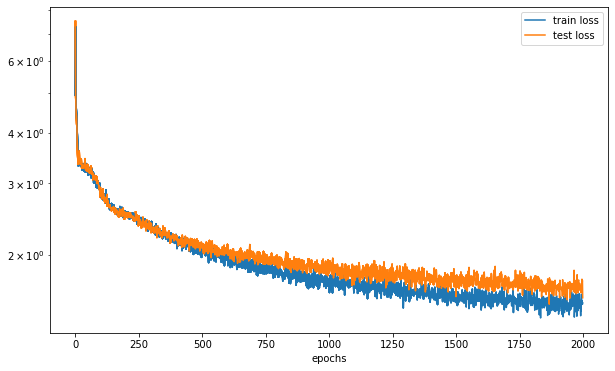

In [235]:
# D2L's multihead attention
start_time = time.time()
train_loss_ls, test_loss_ls = train(net, batch_size, context_len, n_epochs, optimizer, device)
print('Time taken to train:', f'{time.time() - start_time:.2f}', '[s]')

In [236]:
# generate text from model
init_context = torch.tensor([[1]], dtype=torch.long, device=device)
print(decode(net.generate(init_context, maxlen=2000)[0].tolist()))

 not atter.
I am to the join, it is father or ilkness
As depers! Crust, well, begins or the must, sesinful
Thwid wite: not pardien; thought
shed that suster aldetible and beg, throok wash,
Thither dying do the consuments alnioless, as and bearen
These not assire; though fight Solies
That she more thou too our brathee to my troys:
that worth the true deep shall the excuse
A woe's grils.
Midnessless side us whilst I the widow deser
Aready of this a, to the interate him.
Andnence, I to tendime I proseed rage,
And his preached doin best rich togetimes feith!
This present your horses deep with of dispicious
As your lord,-will forth strutch.
To be For this no made with their more constrantate;
Afthoposing ow thou haste of boding's.

EDWARD:
Let 'said west thee still you turs it? Yewill to end
Fite out smile the of smies I may promise wild a wessigh
of Theil, wasting dnowne accure! I present
Scive you tees doublinging, and would fortug,
A ton. Gloucture thy content done.

First Solseen:
Why? 

Time taken to train: 354.36 [s]


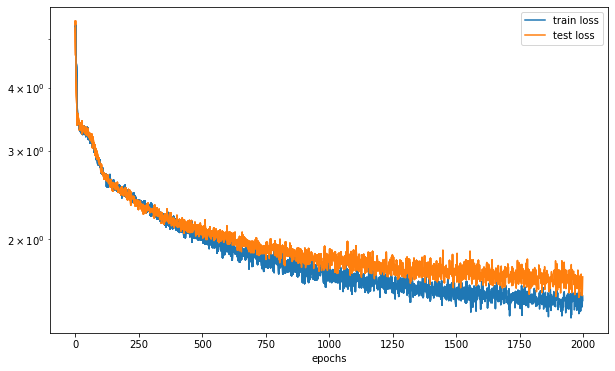

In [227]:
# Karpathy's multihead attention
start_time = time.time()
train_loss_ls, test_loss_ls = train(net, batch_size, context_len, n_epochs, optimizer, device)
print('Time taken to train:', f'{time.time() - start_time:.2f}', '[s]')

In [228]:
# generate text from model
init_context = torch.tensor([[1]], dtype=torch.long, device=device)
print(decode(net.generate(init_context, maxlen=2000)[0].tolist()))

 arvanch: thy weak.

BUCKINGHAM:
In betweer use the bare of thy great is rrow
Against you do plocume woe with come with locks.

ANTOLYCUS:
Prithee, lie blood my lord, in one basgy'd, my came son
And ridly you sings Held Claudio,'d, untoised
Why lasting may the refiteroen less. Fare thou
To stilling, hath the crucl coldier cours?

ISABELLA:
Yea, thou ragedy swear phants?
And I hupby it say,
Not a gentleman's countly father, I shall I bew
He is good our woot-there heers trithee,
For fall Mayius to her to-stue me of poor the night,
And or, and lacken howsion as that swome
For pow misture three in spoil flow o' the circum?

First Seem:
Go, sir, for plock matchme of you'lk for thy Camilors.
Why, I go had hate come: to with heoppes!
Come say, Curia, my lord; look in women!
Who we the daughter
Selighters a life; thou are disconcirance
The ways of the Tweet
Hath would we snain was nother cacution.

LUCIO:
I must, in sue hope day, to Bly cannot Lord?

KING HENRY VI:
Sweet with thee royen his na